In [1]:
import rpy2.ipython
rpy2.ipython.load_ipython_extension(get_ipython())

In [2]:
%%R
library(recount3) 
library(edgeR)
library(SummarizedExperiment)
library(hipathia) 

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiff

In [3]:
%%R
####-- BLOOD
gtex_blood <- subset(available_projects(), file_source == "gtex" & 
                           project =="BLOOD")
rseBLOOD <- create_rse(gtex_blood)
#rseBLOOD <- rseBLOOD[, rseBLOOD$gtex.smtsd == "Whole Blood"]
####--- OVARY
#gtex_ovar <- subset(available_projects(), file_source == "gtex" & 
#                         project =="OVARY")
#rseOVAR <- create_rse(gtex_ovar)
###--- UTERUS
#gtex_uter <- subset(available_projects(), file_source == "gtex" & 
#                          project =="UTERUS")
#rseUTER <- create_rse(gtex_uter)
###--- THYROIDES
gtex_thyr <- subset(available_projects(), file_source == "gtex" & 
                          project =="THYROID")
rseTHYR<- create_rse(gtex_thyr)
    
##--- COOMBINADO
rse <- cbind(rseBLOOD, rseTHYR)
#rse2 <- cbind(rseBLOOD, rseOVAR)

R[write to console]: 2025-08-03 12:24:25.27349 caching file sra.recount_project.MD.gz.

R[write to console]: 2025-08-03 12:24:25.9017 caching file gtex.recount_project.MD.gz.

R[write to console]: 2025-08-03 12:24:26.519994 caching file tcga.recount_project.MD.gz.

R[write to console]: 2025-08-03 12:24:30.283571 downloading and reading the metadata.

R[write to console]: 2025-08-03 12:24:31.238174 caching file gtex.gtex.BLOOD.MD.gz.

R[write to console]: 2025-08-03 12:24:32.285441 caching file gtex.recount_project.BLOOD.MD.gz.

R[write to console]: 2025-08-03 12:24:33.25442 caching file gtex.recount_qc.BLOOD.MD.gz.

R[write to console]: 2025-08-03 12:24:34.326112 caching file gtex.recount_seq_qc.BLOOD.MD.gz.

R[write to console]: 2025-08-03 12:24:35.276305 downloading and reading the feature information.

R[write to console]: 2025-08-03 12:24:35.967694 caching file human.gene_sums.G026.gtf.gz.

R[write to console]: 2025-08-03 12:24:36.431689 downloading and reading the counts: 1048 sam

In [4]:
%%R
## Obtengo por separado un array con los conteso crudos de RNA-seq y los 
## datos clínicos y experimentales en metadata
counts <- assay(rse, "raw_counts")  #Matriz de conteos crudos
metadata <- colData(rse)            #df de datos clínicos y experimentales

In [5]:
%%R
### 2 - PRE-FILTRADOO
keep <- rowSums(counts > 0) >= 5  # Genes expresados en ≥5 muestras
counts <- counts[keep, ] #De 63856 genes a 55424 genes


In [6]:
%%R
## 3 - NORMALIZACIÓN TMM EN DATOS CRUDOS 

    # Normalización TMM = Trimmed Mean of M-values:
    # método para corregir diferencias en la profundidad de secuenciación y 
    # en la composición global del RNA entre muestras.
    # Conversión counts crudos a CPM (Counts Per Million),
    # usando tamaños de librería ajustados con factores de normalización TMM 
    # (calcula lib.size * norm.factors)
dge <- DGEList(counts = counts) # clase DGEList (Differential Gene Expression List)
dge_norm <- cpm(dge, 
                    normalized.lib.sizes = TRUE, 
                    log = FALSE)                              
                     
dge_normalized <- log2(dge_norm + 1) # transformación log2 para obtener valores continuos comparables 

In [7]:
%%R
### 4 - CAMBIO DE ENSEMBL A ENTREZ (Hipathia)
data_entrez <- translate_data(dge_normalized, "hsa")
      # translated ids = 23736 (0.43) 
      # untranslated ids = 31688 (0.57) 
      # multihit ids = 181 (0.0033) 
    ## De los 55424 genes por Ensembl, se reconocen 23638 con id Entrez en Hipathia
table(is.na(rownames(data_entrez)))
    # IMPORTANTE: que no existan filas con id no reconocidos por Hipathia

R[write to console]: snapshotDate(): 2023-10-23



translated ids = 23791 (0.42) 
untranslated ids = 32426 (0.58) 
multihit ids = 186 (0.0033) 

FALSE 
23690 


In [ ]:
%%R
### 5 - NORMALIZACION a [0,1] (Hipathia)
data_entrez_norm <- normalize_data(data_entrez)
    
### 6 - OBJETO FINAL PARA HIPATHIA SummarizedEperiment
data_info <- SummarizedExperiment(
    assays = list(counts = data_entrez_norm), #counts normalizados
     colData = DataFrame(
        tissue = colData(rse)$gtex.smts,
        subtissue = colData(rse)$gtex.smtsd
    )
)

In [ ]:
%%R
### 7 - DESCARGO PATHWAYS HUMANOS (Hipathia)
pathways <- load_pathways("hsa")
        # Loaded 146 pathways
 

In [ ]:
%%R
# Limitar el número de hilos (threads) usados por OpenMP a 1 para evitar que
# funciones paralelizadas (como hipathia) saturen la CPU y provoquen fallos
# o caídas del kernel en entornos interactivos como JupyterLab.
# Esto mejora la estabilidad aunque puede ralentizar el procesamiento.
Sys.setenv(OMP_NUM_THREADS = "1")
    
### 8 - CALCULO DE ACTIVIDAD DE RUTAS
## HIPATHIA - result
results <- hipathia(data_info, pathways) # utiliza las subrutas efectoras
                                             # opción decompose=TRUE utiliza las subrutas descompuestas

In [ ]:
%%R
## Obtengo los valores de actividad de la señal como matriz
path_vals <- get_paths_data(results, matrix = TRUE)
    ## Obtengo los valores de actividad de la señal como SummarizedExperiment
    #path <- get_paths_data(results)
#head(path_vals)  

In [ ]:
%%R
# Datos de tipo de tejido
data_design <- as.matrix(colData(data_info))
sample_group_sub <- data_design[colnames(path_vals),"subtissue"]
sample_group_tissue <- data_design[colnames(path_vals),"tissue"]

### -------- Comparación de las características entre diferentes grupos de muestras
comp <- do_wilcoxon(path_vals, sample_group_tissue, g1 = "Blood", g2 = "Thyroid")
#hhead(comp)

In [ ]:
%%R
pathways_summary <- get_pathways_summary(comp, pathways)

In [ ]:
%%R
##### PCA
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])
pca_plot(pca_model, sample_group_tissue, legend = T, main="BLOOD")


In [ ]:
%%R
comp2 <- do_wilcoxon(path_vals, sample_group_sub, g1 = "Whole Blood")
pathways_summary <- get_pathways_summary(comp2, pathways)
##### PCA
ranked_path_vals <- path_vals[order(comp2$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])
pca_plot(pca_model, sample_group_sub, legend = T, main="BLOOD")

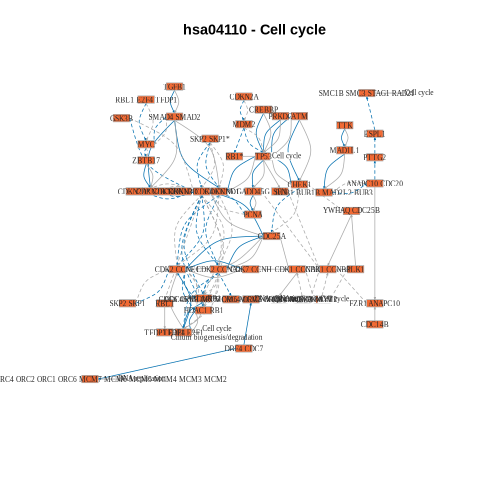

In [16]:
%%R
colors_de <- node_color_per_de(results, pathways, sample_group,"1","Thyroid", 
                                colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa04110",
                        node_colors = colors_de)
#pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa05216",
 #                       node_colors = colors_de)


In [39]:
%%R
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa0491",
                        node_colors = colors_de)

Error in `ensure_igraph()`:
! Must provide a graph object (provided `NULL`).
Run `rlang::last_trace()` to see where the error occurred.

Error in ensure_igraph(graph) :


RInterpreterError: Failed to parse and evaluate line 'pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa0491",\n                        node_colors = colors_de)\n'.
R error message: 'Error in ensure_igraph(graph) :'

In [30]:
%%R
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa0491",
                        node_colors = colors_de)

Error in `ensure_igraph()`:
! Must provide a graph object (provided `NULL`).
Run `rlang::last_trace()` to see where the error occurred.

Error in ensure_igraph(graph) :


RInterpreterError: Failed to parse and evaluate line 'pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa0491",\n                        node_colors = colors_de)\n'.
R error message: 'Error in ensure_igraph(graph) :'

In [ ]:
####PARA TRAER LOS DATOS
from pathlib import Path

# Crea la carpeta si no existe
Path("data").mkdir(exist_ok=True)

# Leer archivo desde ruta relativa
import pandas as pd
df = pd.read_csv(Path("data") / "hipathia_output.csv")